<a href="https://colab.research.google.com/github/madelezhia/vision-systems-lab/blob/main/I-Foundations/CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms
from torchvision.models import resnet34, ResNet34_Weights
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import requests

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


## Load an Imagenet-pretrained ResNet34

In [ ]:
# Load the ResNet34 model pretrained on ImageNet
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

# Set the model in evaluation mode and explore its architecture
model.eval()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 166MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Picking a test image

In [ ]:
sample_image = Image.open('/gdrive/MyDrive/Colab Notebooks/Portfolio/I-Foundations/goldfish-water-temperature-4271540239.jpg')

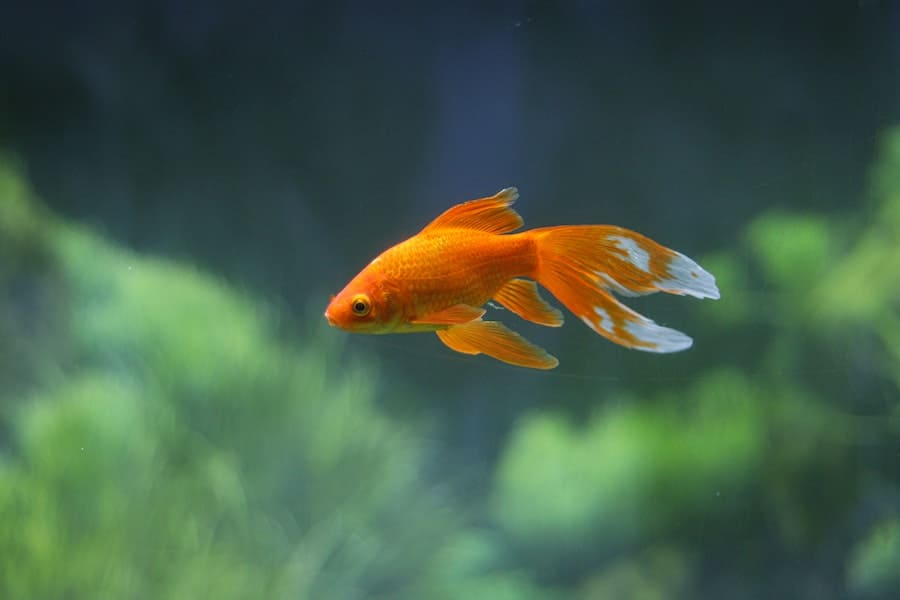

In [ ]:
sample_image

In [ ]:
# Inspect the original transformations applied to the pretrained model
ResNet34_Weights.IMAGENET1K_V1.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

# Apply transform to image (for visualization only)

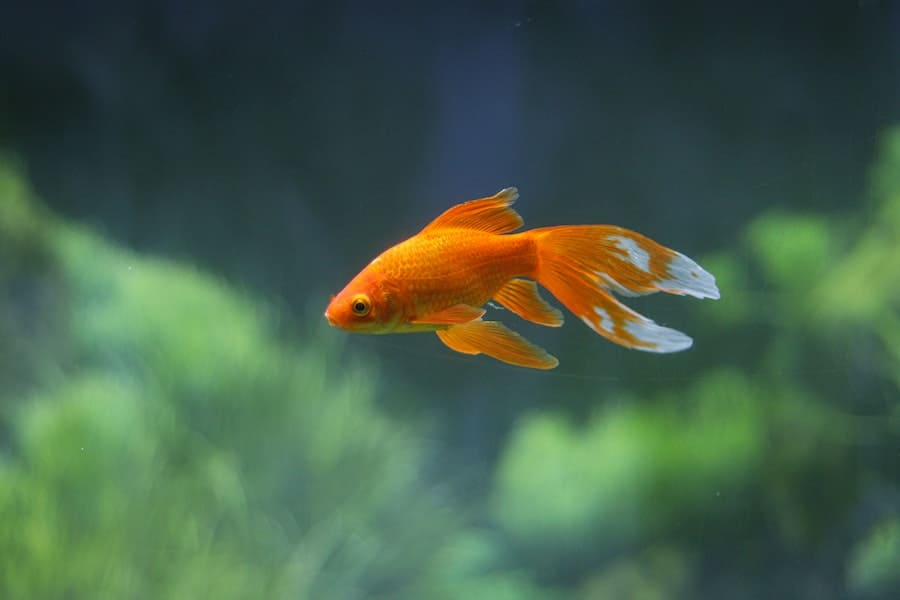

In [ ]:
# Define preprocessing transformations
preprocess = transforms.Compose([
    # Try commenting out the Resize
    transforms.Resize((224, 224)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                     std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the input image
img = Image.fromarray(np.array(sample_image)).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

img

In [ ]:
# Hook for extracting the activations from the last convolutional layer
activations = []
def hook_fn(module, input, output):
    activations.append(output)

In [ ]:
# Inspect the modules inside our model
model._modules

{'conv1': Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 'bn1': BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 'relu': ReLU(inplace=True),
 'maxpool': MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 'layer1': Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(6

In [ ]:
# get the module by name
model._modules.get("layer4")

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1

In [ ]:
# Register the hook
layer_name = 'layer4'  # Last convolutional block
hook = model._modules.get(layer_name).register_forward_hook(hook_fn)

# Forward pass
output = model(input_tensor)

# Remove the hook
hook.remove()

# Get the weights of the fully connected layer
fc_weights = model.fc.weight.detach()

# Select the class index (e.g., 0 for 'tench')
class_idx = torch.argmax(output, dim=1).item()

class_idx

1

In [ ]:
sofmax_output = torch.nn.functional.softmax(output, dim=1)
sofmax_output.squeeze()[class_idx].item()

0.9964827299118042

## Inspect Imagenet1K's classes

In [ ]:
label_mapping = ResNet34_Weights.IMAGENET1K_V1.meta['categories']
label_mapping[:10]

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

In [ ]:
# Get the top 3 predicted probabilities and class indices
topk_probs, topk_indices = torch.topk(sofmax_output, 3)

# Print the results
print("Top 3 Predictions:")
for i in range(3):
  prob = topk_probs.squeeze()[i].item()
  class_idx = topk_indices.squeeze()[i].item()
  class_name = label_mapping[class_idx]
  print(f"class index: {class_idx}, {class_name}, probability = {prob:.2f}")



Top 3 Predictions:
class index: 1, goldfish, probability = 1.00
class index: 862, torch, probability = 0.00
class index: 29, axolotl, probability = 0.00


## CAM Implementation (with Global Average Pooling)

In [ ]:
import torch
import torch.nn.functional as F


weight = fc_weights[class_idx]
act = activations[0][0]

pooled = F.adaptive_avg_pool2d(act.unsqueeze(0), 1)
pooled = pooled.squeeze(0).squeeze(-1).squeeze(-1)


score = (pooled * weight).sum()  # The single scalar logit for class_idx

cam = (act * weight.view(-1, 1, 1)).sum(dim=0)

cam = cam - cam.min()
cam = cam / cam.max()

print(cam.shape)

torch.Size([7, 7])


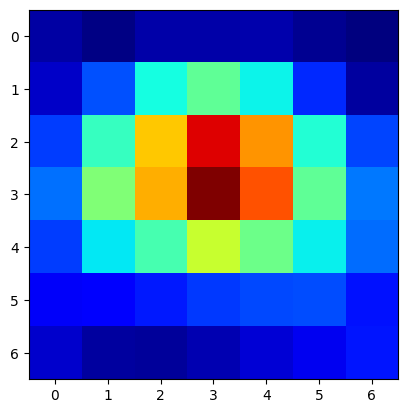

In [ ]:
plt.imshow(cam.detach(), cmap="jet");

In [ ]:
# The activations were originally 512
act.shape

torch.Size([512, 7, 7])

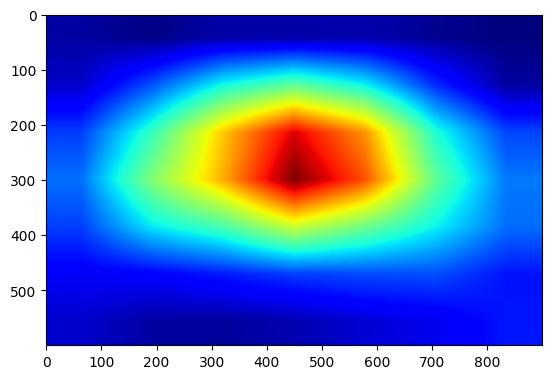

In [ ]:
cam_resized = np.array(Image.fromarray(cam.detach().numpy()).resize(img.size, resample=Image.BILINEAR))
plt.imshow(cam_resized, cmap="jet");

/tmp/ipython-input-75628975.py:23: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(colored_cam_rgb_scaled, mode='RGB')


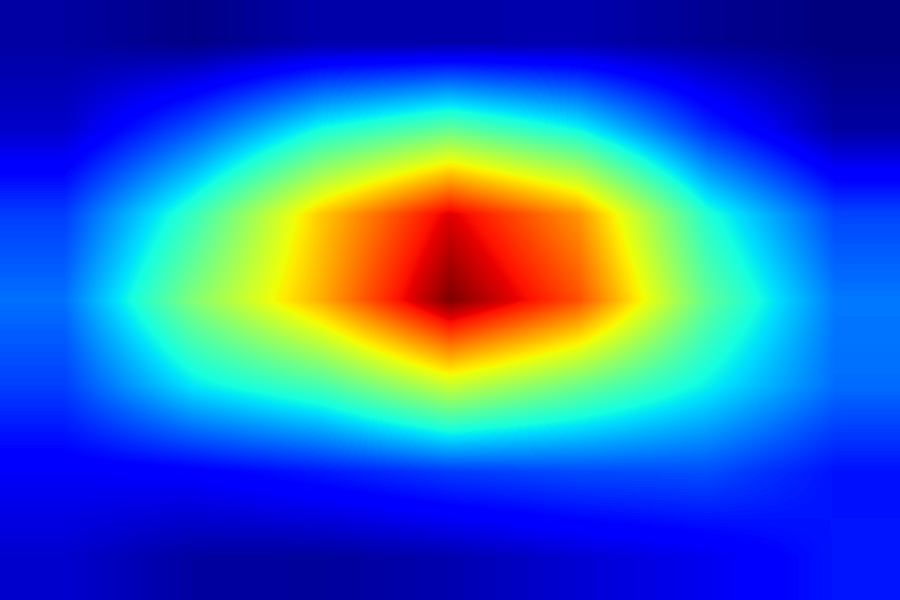

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib

# For a CAM with shape (height, width)
def save_cam_image_with_jet(cam, save_path):
    # Ensure we're working with a 2D array
    cam = cam.squeeze()

    # Apply the jet colormap to the values (still in range [0,1])
    # This converts to an RGBA array with values in [0,1]
    cmap = plt.cm.jet
    colored_cam = cmap(cam)

    # Convert from RGBA to RGB by discarding the alpha channel
    colored_cam_rgb = colored_cam[:, :, :3]

    # Scale to [0,255] and convert to uint8 for PIL
    colored_cam_rgb_scaled = (colored_cam_rgb * 255).astype(np.uint8)

    # Create a PIL Image
    img = Image.fromarray(colored_cam_rgb_scaled, mode='RGB')

    # Save as JPEG
    img.save(save_path, format='JPEG', quality=95)

    return img

# Usage
cam_img = save_cam_image_with_jet(cam_resized, 'class_activation_map.jpg')
cam_img

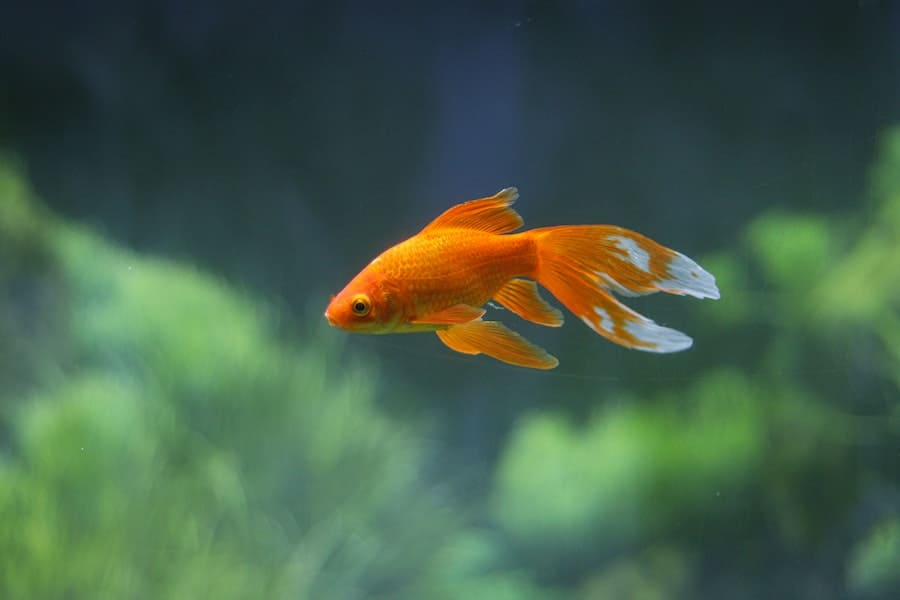

In [ ]:
img

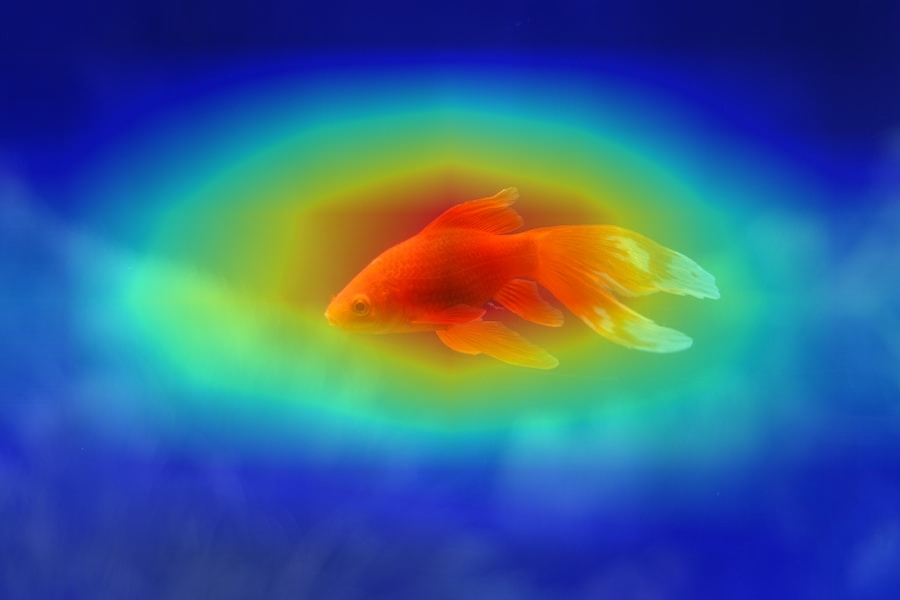

In [ ]:
# @title Image blending {run:"auto"}
# @markdown Level of transparency

slider_value = 0.27  # @param {type: "slider", min: 0.01, max: 0.99, step:0.01}

blended_img = Image.blend(img, cam_img, 0.6)
blended_img
